# Prepare Before Training
- Import require module
- Import data
- Prepare data

In [1]:
# import data from 1121FinalProject.db
import sqlite3

DB_FILE = "1121FinalProject.db"

db = sqlite3.connect(DB_FILE)
c = db.cursor()

# read Nozzle_Temperature, Plate_Temperature, X_axis_Angle, Y_axis_Angle, X, Y, Model, Successful as data
def read_data():

    command = "SELECT Nozzle_Temperature, Plate_Temperature, X_axis_Angle, Y_axis_Angle, X, Y, Model, Successful FROM Printer_data"
    c.execute(command)
    data = c.fetchall()
    return data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional
import pandas as pd

# read data from database
data = read_data()

# trun data into pandas dataframe
data = pd.DataFrame(data)

# shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# split data into x_data and y_data
x_data = data.iloc[:, 0:7]
y_data = data.iloc[:, 7]

# print head of x_data and y_data
print("x_data:", x_data.head())
print("y_data:", y_data.head())

# encoding on y_train and y_test("ture" = 1, "false" = 0)
y_data = y_data.replace("true", 1)
y_data = y_data.replace("false", 0)

# one-hot encoding on y_data
y_data = pd.get_dummies(y_data)

# split data into train and test(80% train, 20% test)
num_train = int(0.8 * len(data))

x_train = x_data[:num_train]
y_train = y_data[:num_train]

x_test = x_data[num_train:]
y_test = y_data[num_train:]

# turn x_train, x_test, y_train, y_test into tensor(datatype: float)
x_train = torch.tensor(x_train.values, dtype=torch.float)
x_test = torch.tensor(x_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

# print out the shape of train and test data
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# show the overview of the y_train and y_test
print('y_train overview:', y_train)
print('y_test overview:', y_test)

OperationalError: no such table: Printer_data

# Model Training 
- create the model
- Train the model
- plot Epoch and Loss

device is cuda
<bound method Module.parameters of MyModel(
  (linear_1): Linear(in_features=7, out_features=20, bias=True)
  (linear_2): Linear(in_features=20, out_features=20, bias=True)
  (linear_3): Linear(in_features=20, out_features=2, bias=True)
  (LogSoftmax): LogSoftmax(dim=0)
  (relu): ReLU()
)>


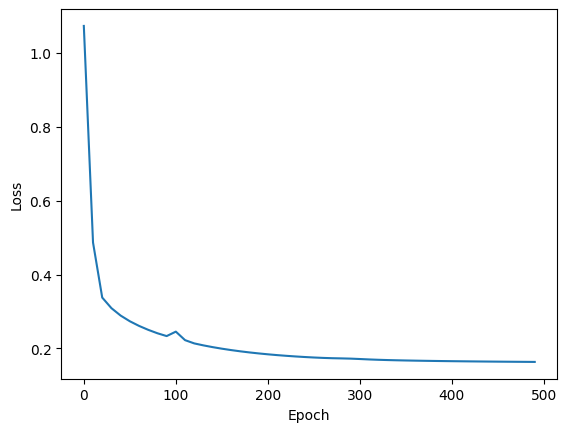

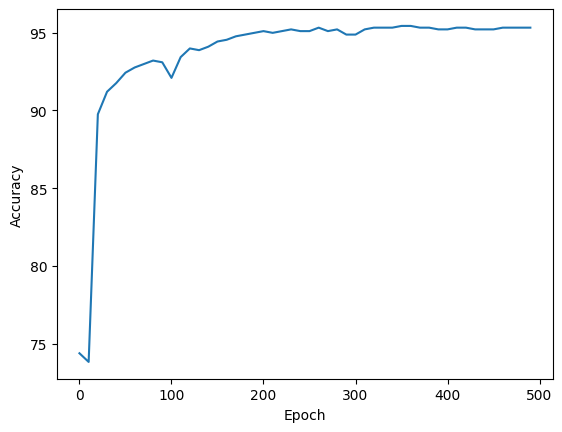

Final loss: 0.1631714254617691
Final accuracy: 95.32293986636972


In [ ]:
# create model

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"# Enable CUDA if possible
print(f"device is {device}")

class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        
        hidden1_dim = 20
        hidden2_dim = 20

        self.linear_1 = nn.Linear(input_dim, hidden1_dim)
        self.linear_2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.linear_3 = nn.Linear(hidden2_dim, output_dim)

        self.LogSoftmax = nn.LogSoftmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        outputs = self.linear_1(inputs).requires_grad_()
        outputs = self.LogSoftmax(outputs).requires_grad_()
        outputs = self.linear_2(outputs).requires_grad_()
        outputs = self.LogSoftmax(outputs).requires_grad_()        
        outputs = self.linear_3(outputs).requires_grad_()
        outputs = self.LogSoftmax(outputs).requires_grad_()

        return outputs
        
# Create an instance of the model and send it to target device
torch.manual_seed(37)
model = MyModel(7, 2).to(device)

print(model.parameters)# Type of parameter object

# Create a loss function
criterion = nn.CrossEntropyLoss()  

# Create an optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(params=model.parameters(),lr=learning_rate)

num_epochs = 500 # Train for longer\
softmax = nn.Softmax(dim=0)
# Put data to target device
inputs, labels = x_train.to(device), y_train.to(device)

# creat a list for store accurcy and loss
loss_list = []
accuracy_list = []

# Train the model
for epoch in range(num_epochs):
    
    predicts = model(inputs).squeeze()
    loss = criterion(predicts,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # store epoch and loss into list every 10 epoch
    if epoch % 10 == 0:
        
        # put loss into cpu
        loss = loss.cpu()
        loss = loss.item()

        # append [epoch, loss] to loss_list
        loss_list.append([epoch, loss])

        # calculate accuracy
        
        # put x_test to target device
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        # get the predict result
        predicts = model(x_test).squeeze()

        # compare the predict result with the test data
        corrects = 0
        for i in range(len(predicts)):
            if torch.argmax(predicts[i]) == torch.argmax(y_test[i]):
                corrects += 1

        accruacy = corrects/len(predicts)*100
        
        #store accuracy into accuracy_list
        accuracy_list.append([epoch, accruacy])
        

# plot loss_list
loss_list = np.array(loss_list)
plt.plot(loss_list[:,0], loss_list[:,1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot accuracy_list
accuracy_list = np.array(accuracy_list)
plt.plot(accuracy_list[:,0], accuracy_list[:,1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# print out the final loss and accuracy
print("Final loss:", loss_list[-1][1])
print("Final accuracy:", accuracy_list[-1][1])